# Example: Graph generation from a gene

This notebook will show you how to use the tool to generate a KG on the underlying data.

In [ ]:
import os

current_dir = os.getcwd()

os.chdir(f"{current_dir}/..")

# Set the current working directory
current_dir = os.getcwd()
print("Current directory:", current_dir)

Current directory: /Users/yojana/Documents/GitHub/pyBiodatafuse


In [2]:
# Import modules
import pickle

import pandas as pd

from pyBiodatafuse import id_mapper
from pyBiodatafuse.annotators import (
    bgee,
    disgenet,
    minerva,
    molmedb,
    opentargets,
    pubchem,
    stringdb,
    wikipathways,
)
from pyBiodatafuse.constants import BGEE_GENE_EXPRESSION_LEVELS_COL, DISGENET_DISEASE_COL
from pyBiodatafuse.graph import generator
from pyBiodatafuse.utils import (
    combine_sources,
    create_harmonized_input_file,
    create_or_append_to_metadata,
)

### Load the input list and convert it to a dataframe

In [ ]:
genes_of_interest = """AAGRN
ALG14
ALG2
CHAT
CHD8
CHRNA1
CHRNB1
CHRND
CHRNE
CHRNG
COL13A1
COLQ
DOK7
DPAGT1
GFPT1
GMPPB
LAMA5
LAMB2
LRP4
MUSK
MYO9A
PLEC
PREPL
PURA
RAPSN
RPH3A
SCN4A
SLC18A3
SLC25A1
SLC5A7
SNAP25
SYT2
TOR1AIP1
UNC13A
VAMP1
DMD"""

gene_list = genes_of_interest.split("\n")
len(gene_list)

36

In [ ]:
data_input = pd.DataFrame(gene_list, columns=["identifier"])
data_input.head()

,identifier
0,AAGRN
1,ALG14
2,ALG2
3,CHAT
4,CHD8


### Entity resolution using BridgeDB

In [ ]:
os.makedirs("examples/data", exist_ok=True)

In [6]:
pickle_path = os.path.join(os.getcwd(), "examples/data/example_gene_list.pkl")
metadata_path = os.path.join(os.getcwd(), "examples/data/example_gene_list_metadata.pkl")

if not os.path.exists(pickle_path):
    bridgedb_df, bridgedb_metadata = id_mapper.bridgedb_xref(
        identifiers=data_input,
        input_species="Human",
        input_datasource="HGNC",
        output_datasource="All",
    )
    bridgedb_df.to_pickle(pickle_path)
    with open(metadata_path, "wb") as file:
        pickle.dump(bridgedb_metadata, file)
else:
    bridgedb_df = pd.read_pickle(pickle_path)
    with open(metadata_path, "rb") as file:
        bridgedb_metadata = pickle.load(file)

In [7]:
print("Number of genes with mapping in BridgeDb:", len(bridgedb_df["identifier"].unique()))
bridgedb_df.head()

Number of genes with mapping in BridgeDb: 35


,identifier,identifier.source,target,target.source
0,ALG14,HGNC,Q96F25,Uniprot-TrEMBL
1,ALG14,HGNC,ALG14,HGNC
2,ALG14,HGNC,ENSG00000172339,Ensembl
3,ALG14,HGNC,199857,NCBI Gene
4,ALG14,HGNC,HGNC:28287,HGNC Accession Number


### Gene expression from Bgee

In [10]:
bgee_path = os.path.join(os.getcwd(), "examples/data/example_bgee.pkl")
bgee_metadata_path = os.path.join(os.getcwd(), "examples/data/example_bgee_metadata.pkl")

if not os.path.exists(bgee_path):
    bgee_df, bgee_metadata = bgee.get_gene_expression(bridgedb_df=bridgedb_df)
    bgee_df.to_pickle(bgee_path)
    with open(bgee_metadata_path, "wb") as file:
        pickle.dump(bgee_metadata, file)
else:
    bgee_df = pd.read_pickle(bgee_path)
    with open(bgee_metadata_path, "rb") as file:
        bgee_metadata = pickle.load(file)

In [11]:
bgee_df[BGEE_GENE_EXPRESSION_LEVELS_COL][0]

[{'anatomical_entity_id': 'UBERON_0000178',
  'anatomical_entity_name': 'blood',
  'expression_level': 60.16422,
  'confidence_level_id': 'CIO_0000029',
  'confidence_level_name': 'high confidence level',
  'developmental_stage_id': 'UBERON_0000104',
  'developmental_stage_name': 'life cycle'},
 {'anatomical_entity_id': 'UBERON_0002371',
  'anatomical_entity_name': 'bone marrow',
  'expression_level': 68.7005,
  'confidence_level_id': 'CIO_0000029',
  'confidence_level_name': 'high confidence level',
  'developmental_stage_id': 'UBERON_0000104',
  'developmental_stage_name': 'life cycle'},
 {'anatomical_entity_id': 'UBERON_0000955',
  'anatomical_entity_name': 'brain',
  'expression_level': 73.14512,
  'confidence_level_id': 'CIO_0000029',
  'confidence_level_name': 'high confidence level',
  'developmental_stage_id': 'UBERON_0000104',
  'developmental_stage_name': 'life cycle'},
 {'anatomical_entity_id': 'UBERON_0000310',
  'anatomical_entity_name': 'breast',
  'expression_level': 73.

### Disease annotatation from DisGeNet


In [12]:
disgenet_api_key = "89ba9e26-dc4d-45de-a92d-79fe45d9ae1c"

In [13]:
disgenet_path = os.path.join(os.getcwd(), "examples/data/example_disgenet.pkl")
disgenet_metadata_path = os.path.join(os.getcwd(), "examples/data/example_disgenet_metadata.pkl")

if not os.path.exists(disgenet_path):
    disgenet_df, disgenet_metadata = disgenet.get_gene_disease(
        api_key=disgenet_api_key, bridgedb_df=bridgedb_df
    )

    disgenet_df.to_pickle(disgenet_path)
    with open(disgenet_metadata_path, "wb") as file:
        pickle.dump(disgenet_metadata, file)
else:
    disgenet_df = pd.read_pickle(disgenet_path)
    with open(disgenet_metadata_path, "rb") as file:
        disgenet_metadata = pickle.load(file)

Querying DisGeNET: 100%|██████████| 35/35 [00:16<00:00,  2.15it/s]
/Users/yojana/Documents/GitHub/pyBiodatafuse/src/pyBiodatafuse/annotators/disgenet.py:293: UserWarning: Not all values in column 'el' have the correct type '<class 'float'>'.
  check_columns_against_constants(


### Disease to compound annotation from OpenTargets

In [14]:
# Prepare the input to use DISGENET output as seed for OpenTargets
disease_mapping_df = create_harmonized_input_file(disgenet_df, DISGENET_DISEASE_COL, "EFO", "UMLS")
disease_mapping_df.head()

,identifier,identifier.source,target,target.source
0,UMLS_C5680989,UMLS,EFO_0700079,EFO
2,UMLS_C0017605,UMLS,EFO_1001506,EFO
3,UMLS_C0751884,UMLS,EFO_0700127,EFO
4,UMLS_C0011581,UMLS,EFO_0004257,EFO
5,UMLS_C0011581,UMLS,EFO_0008623,EFO


In [16]:
opentarget_path = os.path.join(os.getcwd(), "examples/data/example_opentarget_cmpd.pkl")
opentarget_metadata_path = os.path.join(
    os.getcwd(), "examples/data/example_opentarget_cmpd_metadata.pkl"
)

if not os.path.exists(opentarget_path):
    opentargets_df, opentargets_metadata = opentargets.get_disease_compound_interactions(
        disease_mapping_df
    )
    opentargets_df.to_pickle(opentarget_path)
    with open(opentarget_metadata_path, "wb") as file:
        pickle.dump(opentargets_metadata, file)
else:
    opentargets_df = pd.read_pickle(opentarget_path)
    with open(opentarget_metadata_path, "rb") as file:
        opentargets_metadata = pickle.load(file)

Mapping PubChem: 100%|██████████| 752/752 [03:28<00:00,  3.60it/s]
/Users/yojana/Documents/GitHub/pyBiodatafuse/src/pyBiodatafuse/annotators/opentargets.py:1119: UserWarning: Not all values in column 'adverse_effect' have the correct type '<class 'dict'>'.
  check_columns_against_constants(


### Pathways from MINERVA

In [17]:
minerva_path = os.path.join(os.getcwd(), "examples/data/example_minerva.pkl")
minerva_metadata_path = os.path.join(os.getcwd(), "examples/data/example_minerva_metadata.pkl")

if not os.path.exists(minerva_path):
    minerva_df, minerva_metadata = minerva.get_gene_minerva_pathways(
        bridgedb_df, map_name="COVID19 Disease Map"
    )
    minerva_df.to_pickle(minerva_path)
    with open(minerva_metadata_path, "wb") as file:
        pickle.dump(minerva_metadata, file)

else:
    minerva_df = pd.read_pickle(minerva_path)
    with open(minerva_metadata_path, "rb") as file:
        minerva_metadata = pickle.load(file)

/var/folders/x2/1tdvwk7x2_n98kzwy7rnt3t00000gn/T/ipykernel_51688/2116567606.py:5: UserWarning: There is no annotation for your input list in MINERVA, project COVID19 Disease Map.
  minerva_df, minerva_metadata = minerva.get_gene_minerva_pathways(


In [18]:
minerva_metadata

{'datasource': 'MINERVA',
 'metadata': {'source_version': '18.0.1'},
 'query': {'size': 35,
  'input_type': 'Ensembl',
  'MINERVA project': 'COVID19 Disease Map',
  'time': '0:01:03.577905',
  'date': '2024-11-06 18:03:00',
  'url': 'https://covid19map.elixir-luxembourg.org/minerva/'}}

### Pathways from WikiPathways

In [19]:
wikipathways_path = os.path.join(os.getcwd(), "examples/data/example_wikipathway.pkl")
wikipathways_metadata_path = os.path.join(
    os.getcwd(), "examples/data/example_wikipathway_metadata.pkl"
)

if not os.path.exists(wikipathways_path):
    wikipathways_df, wikipathways_metadata = wikipathways.get_gene_wikipathways(
        bridgedb_df=bridgedb_df
    )
    wikipathways_df.to_pickle(wikipathways_path)
    with open(wikipathways_metadata_path, "wb") as file:
        pickle.dump(wikipathways_metadata, file)

else:
    wikipathways_df = pd.read_pickle(wikipathways_path)
    with open(wikipathways_metadata_path, "rb") as file:
        wikipathways_metadata = pickle.load(file)

Querying WikiPathways: 100%|██████████| 2/2 [00:01<00:00,  1.30it/s]


### Reactome pathways from OpenTargets

In [20]:
opentargets_reactome_path = os.path.join(os.getcwd(), "examples/data/example_ot_reactome.pkl")
opentargets_reactome_metadata_path = os.path.join(
    os.getcwd(), "examples/data/example_ot_reactome_metadata.pkl"
)

if not os.path.exists(opentargets_reactome_path):
    opentargets_reactome_df, opentargets_reactome_metadata = opentargets.get_gene_reactome_pathways(
        bridgedb_df=bridgedb_df
    )
    opentargets_reactome_df.to_pickle(opentargets_reactome_path)
    with open(opentargets_reactome_metadata_path, "wb") as file:
        pickle.dump(opentargets_reactome_metadata, file)
else:
    opentargets_reactome_df = pd.read_pickle(opentargets_reactome_path)
    with open(opentargets_reactome_metadata_path, "rb") as file:
        opentargets_reactome_metadata = pickle.load(file)

Processing gene-pathway interactions: 100%|██████████| 35/35 [00:00<00:00, 1061.77it/s]


### Gene Ontology from OpenTargets

In [22]:
opentargets_go_path = os.path.join(os.getcwd(), "examples/data/example_ot_go.pkl")
opentargets_go_metadata_path = os.path.join(os.getcwd(), "examples/data/example_ot_go_metadata.pkl")

if not os.path.exists(opentargets_go_path):
    opentargets_go_df, opentargets_go_metadata = opentargets.get_gene_go_process(
        bridgedb_df=bridgedb_df
    )
    opentargets_go_df.to_pickle(opentargets_go_path)
    with open(opentargets_go_metadata_path, "wb") as file:
        pickle.dump(opentargets_go_metadata, file)
else:
    opentargets_go_df = pd.read_pickle(opentargets_go_path)
    with open(opentargets_go_metadata_path, "rb") as file:
        opentargets_go_metadata = pickle.load(file)

Processing gene annotation: 100%|██████████| 35/35 [00:00<00:00, 409.52it/s]


### Compounds from OpenTarget

In [ ]:
opentargets_gene_path = os.path.join(os.getcwd(), "examples/data/example_ot_gene_cmpd.pkl")
opentargets_gene_metadata_path = os.path.join(
    os.getcwd(), "examples/data/example_ot_gene_cmpd_metadata.pkl"
)

if not os.path.exists(opentargets_gene_path):
    opentargets_compound_df, opentargets_compound_metadata = (
        opentargets.get_gene_compound_interactions(bridgedb_df=bridgedb_df)
    )
    opentargets_compound_df.to_pickle(opentargets_gene_path)
    with open(opentargets_gene_metadata_path, "wb") as file:
        pickle.dump(opentargets_compound_metadata, file)

else:
    opentargets_compound_df = pd.read_pickle(opentargets_gene_path)
    with open(opentargets_gene_metadata_path, "rb") as file:
        opentargets_compound_metadata = pickle.load(file)

Mapping PubChem: 100%|██████████| 56/56 [00:01<00:00, 44.55it/s]
/Users/yojana/Documents/GitHub/pyBiodatafuse/src/pyBiodatafuse/annotators/opentargets.py:599: UserWarning: Not all values in column 'adverse_effect_count' have the correct type '<class 'int'>'.
  check_columns_against_constants(
/Users/yojana/Documents/GitHub/pyBiodatafuse/src/pyBiodatafuse/annotators/opentargets.py:599: UserWarning: Not all values in column 'adverse_effect' have the correct type '<class 'dict'>'.
  check_columns_against_constants(


### Transporter inhibitors from MolMeDB

In [24]:
molmedb_path = os.path.join(os.getcwd(), "examples/data/example_ot_gene_cmpd.pkl")
molmedb_metadata_path = os.path.join(os.getcwd(), "examples/data/example_ot_gene_cmpd_metadata.pkl")

if not os.path.exists(molmedb_path):
    inhibitor_df, inhibitor_metadata = molmedb.get_gene_compound_inhibitor(bridgedb_df=bridgedb_df)
    inhibitor_df.to_pickle(molmedb_path)
    with open(molmedb_metadata_path, "wb") as file:
        pickle.dump(inhibitor_metadata, file)
else:
    inhibitor_df = pd.read_pickle(molmedb_path)
    with open(molmedb_metadata_path, "rb") as file:
        inhibitor_metadata = pickle.load(file)

### Screening results of compounds on proteins encoded by genes annotation by PubChem

In [25]:
pubchem_path = os.path.join(os.getcwd(), "examples/data/example_pubchem.pkl")
pubchem_metadata_path = os.path.join(os.getcwd(), "examples/data/example_pubchem_metadata.pkl")

if not os.path.exists(pubchem_path):
    pubchem_assay_df, pubchem_assay_metadata = pubchem.get_protein_compound_screened(
        bridgedb_df=bridgedb_df
    )
    pubchem_assay_df.to_pickle(pubchem_path)
    with open(pubchem_metadata_path, "wb") as file:
        pickle.dump(pubchem_assay_metadata, file)

else:
    pubchem_assay_df = pd.read_pickle(pubchem_path)
    with open(pubchem_metadata_path, "rb") as file:
        pubchem_assay_metadata = pickle.load(file)

/var/folders/x2/1tdvwk7x2_n98kzwy7rnt3t00000gn/T/ipykernel_51688/1168625326.py:5: UserWarning: There is no annotation for your input list in PubChem.
  pubchem_assay_df, pubchem_assay_metadata = pubchem.get_protein_compound_screened(


### Protein-Protein interactions from STRING

In [ ]:
string_path = os.path.join(os.getcwd(), "examples/data/example_string.pkl")
string_metadata_path = os.path.join(os.getcwd(), "examples/data/example_string_metadata.pkl")

if not os.path.exists(string_path):
    ppi_df, ppi_metadata = stringdb.get_ppi(bridgedb_df=bridgedb_df)
    ppi_df.to_pickle(string_path)
    with open(string_metadata_path, "wb") as file:
        pickle.dump(ppi_metadata, file)
else:
    ppi_df = pd.read_pickle(string_path)
    with open(string_metadata_path, "rb") as file:
        ppi_metadata = pickle.load(file)

/Users/yojana/Documents/GitHub/pyBiodatafuse/src/pyBiodatafuse/annotators/stringdb.py:203: UserWarning: Not all values in column 'score' have the correct type '<class 'int'>'.
  check_columns_against_constants(


### Combing all the results into single dataframe

In [ ]:
combined_df = combine_sources(
    bridgedb_df,
    [
        bgee_df,
        disgenet_df,
        minerva_df,
        wikipathways_df,
        opentargets_reactome_df,
        opentargets_go_df,
        opentargets_compound_df,
        inhibitor_df,
        pubchem_assay_df,
        ppi_df,
    ],
)
combined_df.head()

,identifier,identifier.source,target,target.source,Bgee_gene_expression_levels,DISGENET_diseases,WikiPathways,OpenTargets_reactome,OpenTargets_go,OpenTargets_gene_compounds_x,OpenTargets_gene_compounds_y,StringDB_ppi
0,ALG14,HGNC,ENSG00000172339,Ensembl,"[{'anatomical_entity_id': 'UBERON_0000178', 'a...",[{'disease_name': 'Carbohydrate Deficient Glyc...,"[{'pathway_id': 'WP:WP5153', 'pathway_label': ...",[{'pathway_label': 'Biosynthesis of the N-glyc...,"[{'go_id': 'GO:0043541', 'go_name': 'UDP-N-ace...","[{'chembl_id': nan, 'drugbank_id': nan, 'compo...","[{'chembl_id': nan, 'drugbank_id': nan, 'compo...","[{'stringdb_link_to': 'CHRND', 'Ensembl': 'Ens..."
1,ALG2,HGNC,ENSG00000119523,Ensembl,"[{'anatomical_entity_id': 'UBERON_0000178', 'a...",[{'disease_name': 'CONGENITAL DISORDER OF GLYC...,"[{'pathway_id': 'WP:WP5153', 'pathway_label': ...",[{'pathway_label': 'Biosynthesis of the N-glyc...,"[{'go_id': 'GO:0000033', 'go_name': 'alpha-1,3...","[{'chembl_id': nan, 'drugbank_id': nan, 'compo...","[{'chembl_id': nan, 'drugbank_id': nan, 'compo...","[{'stringdb_link_to': 'GMPPB', 'Ensembl': 'Ens..."
2,CHAT,HGNC,ENSG00000070748,Ensembl,"[{'anatomical_entity_id': 'UBERON_0000955', 'a...","[{'disease_name': 'FIMG2, FORMERLY', 'HPO': No...","[{'pathway_id': 'WP:WP5352', 'pathway_label': ...","[{'pathway_label': 'Synthesis of PC', 'pathway...","[{'go_id': 'GO:0004102', 'go_name': 'choline O...","[{'chembl_id': nan, 'drugbank_id': nan, 'compo...","[{'chembl_id': nan, 'drugbank_id': nan, 'compo...","[{'stringdb_link_to': 'SLC5A7', 'Ensembl': 'En..."
3,CHD8,HGNC,ENSG00000100888,Ensembl,"[{'anatomical_entity_id': 'UBERON_0000178', 'a...","[{'disease_name': 'AUTISM SPECTRUM DISORDER', ...","[{'pathway_id': 'WP:WP428', 'pathway_label': '...",[{'pathway_label': 'Deactivation of the beta-c...,"[{'go_id': 'GO:0005654', 'go_name': 'nucleopla...","[{'chembl_id': nan, 'drugbank_id': nan, 'compo...","[{'chembl_id': nan, 'drugbank_id': nan, 'compo...","[{'stringdb_link_to': nan, 'Ensembl': nan, 'sc..."
4,CHRNA1,HGNC,ENSG00000138435,Ensembl,"[{'anatomical_entity_id': 'UBERON_0000178', 'a...",[{'disease_name': 'MULTIPLE PTERYGIUM SYNDROME...,"[{'pathway_id': nan, 'pathway_label': nan, 'pa...",[{'pathway_label': 'Highly calcium permeable n...,"[{'go_id': 'GO:0050905', 'go_name': 'neuromusc...","[{'chembl_id': 'CHEMBL:CHEMBL1201248', 'drugba...","[{'chembl_id': 'CHEMBL:CHEMBL1201248', 'drugba...","[{'stringdb_link_to': 'CHRND', 'Ensembl': 'Ens..."


In [28]:
combined_df.shape

(35, 12)

In [29]:
combined_df.to_pickle("examples/data/combined_df.pkl")

In [ ]:
# Shuffling the rows
import numpy as np

combined_df["DISGENET_diseases"] = combined_df["DISGENET_diseases"].apply(np.random.permutation)

In [30]:
combined_metadata = create_or_append_to_metadata(
    bridgedb_metadata,
    [
        bgee_metadata,
        disgenet_metadata,
        opentargets_metadata,
        opentargets_compound_metadata,
        inhibitor_metadata,
        pubchem_assay_metadata,
        ppi_metadata,
        wikipathways_metadata,
        minerva_metadata,
        opentargets_reactome_metadata,
        opentargets_go_metadata,
    ],
)

### Exporting the database in pickle format

In [31]:
combined_df.to_pickle("examples/data/example_df_shuffled.pkl")

with open("example_metadata.pkl", "wb") as out:
    pickle.dump(combined_metadata, out)

with open("opentargets_disease_compound_df.pkl", "wb") as out:
    pickle.dump(opentargets_metadata, out)

## Creating a graph from the annotated dataframe

In [32]:
pygraph = generator.save_graph(
    combined_df=combined_df,
    combined_metadata=combined_metadata,
    disease_compound=opentargets_df,
    graph_name="examples",
    graph_dir="./data",
)

Combined DataFrame saved in ./data/examples/examples_df.pkl
Metadata saved in ./data/examples/examples_metadata.pkl
Building graph: 100%|██████████| 35/35 [00:00<00:00, 1523.46it/s]
Graph is built successfully
Graph saved in ./data/examples/examples_graph.pkl and ./data/examples/examples_graph.gml


#### Cytosacpe
Make sure that the Cytoscape is open

In [ ]:
from pyBiodatafuse.graph import cytoscape

cytoscape.load_graph(pygraph, network_name="Test network")

#### Neo4j

In [37]:
from pyBiodatafuse.graph import neo4j

neo4j.save_graph_to_graphml(pygraph, "networkx_graph_test.graphml")

##### Steps to load the graph in Neo4j

- Add `.graphml` file in **import** subfolder of the DBMS folder
- Install apoc plugin
- Create `apoc.conf` file:
    ```
    apoc.trigger.enabled=true
    apoc.import.file.enabled=true
    apoc.export.file.enabled=true
    apoc.import.file.use_neo4j_config=true
    ```
- Add `apoc.conf` file to **conf** subfolder of the DBMS folder
- Open Neo4j Browser
- (Optionl, only run if you have imported a graph  before) Remove all the nodes before importing `.graphml` file

    ```MATCH (n) DETACH DELETE n```

- Import `.graphml` file

    ```call apoc.import.graphml('file:///networkx_graph_test.graphml',{readLabels:TRUE})```

- Add indexes after importing the graph for improving the performance of queries

    ```
    create index Gene for (n:Gene) on (n.node_type)
    create index Pathway for (n:Pathway) on (n.node_type)
    create index `Biological Process` for (n:`Biological Process`) on (n.node_type)
    create index `Molecular Function` for (n:`Molecular Function`) on (n.node_type)
    create index `Cellular Component` for (n:`Cellular Component`) on (n.node_type)
    create index Disease for (n:Disease) on (n.node_type)
    create index Compound for (n:Compound) on (n.node_type)
    create index `Side Effect` for (n:`Side Effect`) on (n.node_type)
    ```
    

- Count the number of each node type
    - total (```MATCH (n) RETURN count(n)```) 
        - Gene (```MATCH (n:Gene) RETURN count(n)```)
        - Pathway (```MATCH (n:Pathway) RETURN count(n)```)
            - WikiPathways (```MATCH (n:Pathway {source: "WikiPathways"}) RETURN count(n)```) 
            - OpenTargets, Reactome (```MATCH (n:Pathway {source: "OpenTargets"}) RETURN count(n)```) 
            - MINERVA (```MATCH (n:Pathway {source: "MINERVA"}) RETURN count(n)```) 
        - Biological Process (```MATCH (n:`Biological Process`) RETURN count(n)```) 
        - Molecular Function (```MATCH (n:`Molecular Function`) RETURN count(n)```) 
        - Cellular Component (```MATCH (n:`Cellular Component`) RETURN count(n)```) 
        - Disease (```MATCH (n:Disease) RETURN count(n)```) 
        - Compound (```MATCH (n:Compound) RETURN count(n)```)
        - Side Effect (```MATCH (n:`Side Effect`) RETURN count(n)```) 
- Count the number of each edge type
    - total (```MATCH ()-[r]->() RETURN count(r)```) 
        - interacts_with (```MATCH ()-[r:interacts_with]->() RETURN count(r)```) 
        - part_of (```MATCH ()-[r:part_of]->() RETURN count(r)```) 
            - WikiPathways (```MATCH ()-[r:part_of {source: "WikiPathways"}]->() RETURN count(r)```) 
            - OpenTargets, Reactome (```MATCH ()-[r:part_of {source: "OpenTargets"}]->() RETURN count(r)```) 
            - MINERVA (```MATCH ()-[r:part_of {source: "MINERVA"}]->() RETURN count(r)```) 
        - activates (```MATCH ()-[r:activates]->() RETURN count(r)```) 
        - treats (```MATCH ()-[r:treats]->() RETURN count(r)```) 
        - has_side_effect (```MATCH ()-[r:has_side_effect]->() RETURN count(r)```) 
        - inhibits (```MATCH ()-[r:inhibits]->() RETURN count(r)```) = 71
        - associated_with (```MATCH ()-[r:associated_with]->() RETURN count(r)```) 

- Export the graph as a `.csv` file

    ```call apoc.export.csv.all("networkx_graph_test.csv",{})```

### RDF

In [75]:
g = rdf.generate_rdf(df=combined_df,
    base_uri="https://biodatafuse.org/example/",
    version_iri="https://biodatafuse.org/example/test.owl",
    orcid="https://orcid.org/0000-0002-4166-7093",
    author="Javier Millan Acosta",
    metadata=None,
    open_only=True,
    load_ontology=False
    )

In [76]:
g.serialize('BDF_example_graph.ttl', format='ttl')

<Graph identifier=N0a0629d325d34d128f50d9f0be04a177 (<class 'rdflib.graph.Graph'>)>

PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX ex: <http://example.org/>
PREFIX weso-s: <http://weso.es/shapes/>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX graph: <https://biodatafuse.org/example/>
PREFIX brick: <https://brickschema.org/schema/Brick#>
PREFIX csvw: <http://www.w3.org/ns/csvw#>
PREFIX dc: <http://purl.org/dc/elements/1.1/>
PREFIX dcat: <http://www.w3.org/ns/dcat#>
PREFIX dcmitype: <http://purl.org/dc/dcmitype/>
PREFIX dcterms: <http://purl.org/dc/terms/>
PREFIX dcam: <http://purl.org/dc/dcam/>
PREFIX doap: <http://usefulinc.com/ns/doap#>
PREFIX foaf: <http://xmlns.com/foaf/0.1/>
PREFIX geo: <http://www.opengis.net/ont/geosparql#>
PREFIX odrl: <http://www.w3.org/ns/odrl/2/>
PREFIX org: <http://www.w3.org/ns/org#>
PREFIX prof: <http://www.w3.org/ns/dx/prof/>
PREFIX prov: <http://www.w3.org/ns/prov#>
PREFIX qb: <http://purl.org/linked-data/cube#>
PREFIX schema: <https://schema.org/>
PREFIX sh: <http:

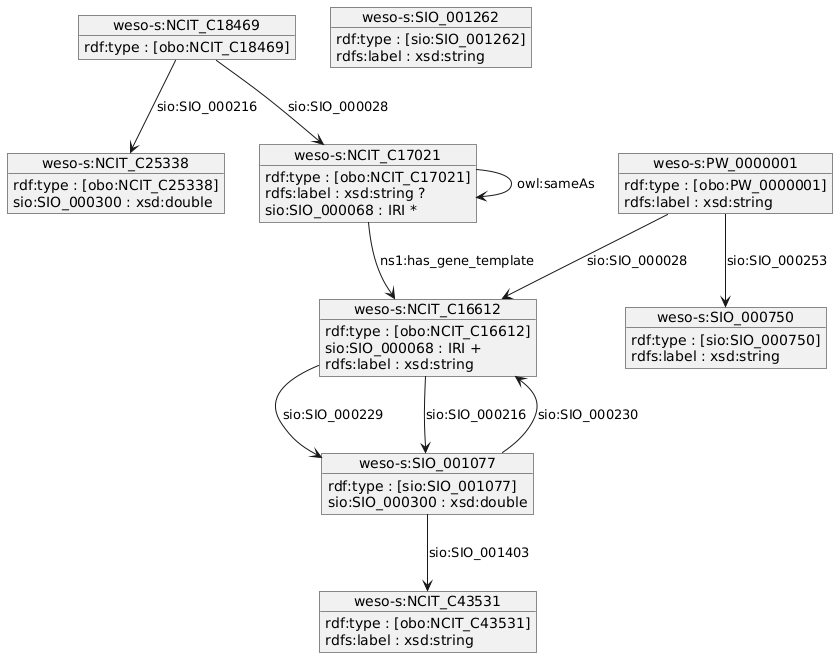

In [77]:
from shexer.shaper import Shaper
from shexer.consts import TURTLE
# Namespace-prefix pair to prettify the results
namespaces_dict = {
    "http://www.w3.org/1999/02/22-rdf-syntax-ns#": "rdf",
    "http://example.org/": "ex",
    "http://weso.es/shapes/": "",
    "http://www.w3.org/2001/XMLSchema#": "xsd",
    "http://www.w3.org/2002/07/owl#": "owl",
    "https://biodatafuse.org/example/" : "graph"
}
graph_path = os.path.join(os.getcwd(), "BDF_example_graph.ttl")

shaper = Shaper(
    all_classes_mode=True,
    graph_file_input=graph_path,
    input_format=TURTLE,
    namespaces_dict=namespaces_dict,
)  # Default rdf:type
rdf_png_path = os.path.join(os.getcwd(), "bdf_shexer.png")

graph_shex = shaper.shex_graph(string_output=True, acceptance_threshold=0.1, to_uml_path=rdf_png_path)
print(graph_shex)
from IPython.display import Image

Image(filename="bdf_shexer.png")

In [78]:
with open("graph_shex.ttl", "w") as f:
    f.write(graph_shex)

### SPARQL queries

This section displays some of the sample queries included in [SPARQL/queries.ttl](SPARQL/queries.ttl)

In [204]:
import requests
def send_sparql_query(query, endpoint="http://localhost:8899/sparql", format="text/csv"):
    headers = {"Accept": format}
    params = {"query": query}
    response = requests.get(endpoint, headers=headers, params=params)

    # Check if request was successful
    if response.status_code == 200:
        if format == "text/csv":
            # Convert CSV response to pandas DataFrame
            from io import StringIO

            csv_data = StringIO(response.text)
            return pd.read_csv(csv_data)
        else:
            return response.text  # For other formats if needed
    else:
        raise Exception(f"Query failed with status code {response.status_code}: {response.text}")

In [219]:
from rdflib import Graph, RDF, SH, RDFS
# Load the graph
query_g = Graph()
with open("SPARQL/queries.ttl", "r") as f:
    query_g.parse(f, format="turtle")

# Extract queries and comments into a list of dictionaries
queries_list = []
for s in query_g.subjects(RDF.type, SH.SPARQLSelectExecutable):
    query_text = query_g.value(s, SH.select)
    comment = query_g.value(s, RDFS.comment)

    if query_text and comment:
        # Append a dictionary for each query and its comment
        queries_list.append({"comment": comment.value, "query": query_text.value})

In [ ]:
query_0 = send_sparql_query(queries_list[0]["query"])
print(queries_list[0]["comment"])
print(queries_list[0]["query"])
query_0

Retrieve details about each gene in the dataset, including the pathways it participates in, and the expression levels tied to it together with its associated anatomical entity and developmental stage. Return the text labels for all entities.

PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX sio: <http://semanticscience.org/resource/>
PREFIX obo: <http://purl.obolibrary.org/obo/>

SELECT ?gene ?geneLabel ?pathway ?pathwayLabel ?expressionMetric ?expressionValue ?anatomicalEntity ?anatomicalEntityLabel ?developmentalStage ?developmentalStageLabel
WHERE {
    ?gene a obo:NCIT_C16612 ;
          sio:SIO_000068 ?pathway ;
          sio:SIO_000216 ?expressionMetric ;
          rdfs:label ?geneLabel .
    ?anatomicalEntity rdfs:label ?anatomicalEntityLabel ;
          a sio:SIO_001262 .
    ?developmentalStage rdfs:label ?developmentalStageLabel ;
          a obo:NCIT_C43531 .
    ?expressionMetric sio:SIO_000300 ?expressionValue ;
          sio:SIO_001403 ?anatomicalEntity ;
     

,gene,geneLabel,pathway,pathwayLabel,expressionMetric,expressionValue,anatomicalEntity,anatomicalEntityLabel,developmentalStage,developmentalStageLabel
0,http://identifiers.org/ensembl#ENSG00000007314,SCN4A,https://reactome.org/content/detail/R-HSA-445095,Interaction between L1 and Ankyrins,https://biodatafuse.org/example/gene_expressio...,48.6239,http://purl.obolibrary.org/obo/UBERON_0000178,blood,http://purl.obolibrary.org/obo/UBERON_0000104,life cycle
1,http://identifiers.org/ensembl#ENSG00000007314,SCN4A,https://reactome.org/content/detail/R-HSA-5576892,Phase 0 - rapid depolarisation,https://biodatafuse.org/example/gene_expressio...,48.6239,http://purl.obolibrary.org/obo/UBERON_0000178,blood,http://purl.obolibrary.org/obo/UBERON_0000104,life cycle
2,http://identifiers.org/ensembl#ENSG00000007314,SCN4A,https://reactome.org/content/detail/R-HSA-445095,Interaction between L1 and Ankyrins,https://biodatafuse.org/example/gene_expressio...,59.0320,http://purl.obolibrary.org/obo/UBERON_0000310,breast,http://purl.obolibrary.org/obo/UBERON_0000104,life cycle
3,http://identifiers.org/ensembl#ENSG00000007314,SCN4A,https://reactome.org/content/detail/R-HSA-5576892,Phase 0 - rapid depolarisation,https://biodatafuse.org/example/gene_expressio...,59.0320,http://purl.obolibrary.org/obo/UBERON_0000310,breast,http://purl.obolibrary.org/obo/UBERON_0000104,life cycle
4,http://identifiers.org/ensembl#ENSG00000115665,SLC5A7,https://reactome.org/content/detail/R-HSA-264642,Acetylcholine Neurotransmitter Release Cycle,https://biodatafuse.org/example/gene_expressio...,42.0832,http://purl.obolibrary.org/obo/UBERON_0000948,heart,http://purl.obolibrary.org/obo/UBERON_0000104,life cycle
...,...,...,...,...,...,...,...,...,...,...
2236,http://identifiers.org/ensembl#ENSG00000198947,DMD,https://www.wikipathways.org/pathways/WP383,Striated muscle contraction pathway,https://biodatafuse.org/example/gene_expressio...,63.5326,http://purl.obolibrary.org/obo/UBERON_0005057,immune organ,http://purl.obolibrary.org/obo/UBERON_0000104,life cycle
2237,http://identifiers.org/ensembl#ENSG00000198947,DMD,https://www.wikipathways.org/pathways/WP4298,Acute viral myocarditis,https://biodatafuse.org/example/gene_expressio...,63.5326,http://purl.obolibrary.org/obo/UBERON_0005057,immune organ,http://purl.obolibrary.org/obo/UBERON_0000104,life cycle
2238,http://identifiers.org/ensembl#ENSG00000198947,DMD,https://www.wikipathways.org/pathways/WP5343,Abnormal calcium handling and its effects on m...,https://biodatafuse.org/example/gene_expressio...,63.5326,http://purl.obolibrary.org/obo/UBERON_0005057,immune organ,http://purl.obolibrary.org/obo/UBERON_0000104,life cycle
2239,http://identifiers.org/ensembl#ENSG00000198947,DMD,https://www.wikipathways.org/pathways/WP5356,Affected pathways in Duchenne muscular dystrophy,https://biodatafuse.org/example/gene_expressio...,63.5326,http://purl.obolibrary.org/obo/UBERON_0005057,immune organ,http://purl.obolibrary.org/obo/UBERON_0000104,life cycle


In [221]:
query_1 = send_sparql_query(queries_list[1]["query"])
print(queries_list[1]["comment"])
print(queries_list[1]["query"])
query_1

Identify pathways that involve multiple genes, and show which sources provide data on these gene-pathway associations.

PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX sio: <http://semanticscience.org/resource/>
PREFIX obo: <http://purl.obolibrary.org/obo/>

SELECT ?pathway ?pathwayLabel (COUNT(?gene) AS ?geneCount) (GROUP_CONCAT(DISTINCT ?sourceLabel; separator=", ") AS ?sources)
WHERE {
    ?pathway a obo:PW_0000001 ;
             sio:SIO_000028 ?gene ;
             sio:SIO_000253 ?source ;
             rdfs:label ?pathwayLabel .
    ?gene a obo:NCIT_C16612 .
    ?source rdfs:label ?sourceLabel .
} 
GROUP BY ?pathway ?pathwayLabel
HAVING (COUNT(?gene) > 1)



,pathway,pathwayLabel,geneCount,sources
0,https://reactome.org/content/detail/R-HSA-1474228,Degradation of the extracellular matrix,2,"OpenTargets_reactome, Reactome"
1,https://reactome.org/content/detail/R-HSA-446205,Synthesis of GDP-mannose,2,"OpenTargets_reactome, Reactome"
2,https://reactome.org/content/detail/R-HSA-3769402,Deactivation of the beta-catenin transactivati...,2,"OpenTargets_reactome, Reactome"
3,https://reactome.org/content/detail/R-HSA-8948216,Collagen chain trimerization,2,"OpenTargets_reactome, Reactome"
4,https://reactome.org/content/detail/R-HSA-212676,Dopamine Neurotransmitter Release Cycle,2,"OpenTargets_reactome, Reactome"
...,...,...,...,...
70,https://reactome.org/content/detail/R-HSA-449836,Other interleukin signaling,2,"OpenTargets_reactome, Reactome"
71,https://reactome.org/content/detail/R-HSA-428643,Organic anion transporters,2,"OpenTargets_reactome, Reactome"
72,https://www.wikipathways.org/pathways/WP706,Sudden infant death syndrome (SIDS) susceptibi...,2,WikiPathways
73,https://reactome.org/content/detail/R-HSA-264642,Acetylcholine Neurotransmitter Release Cycle,8,"OpenTargets_reactome, Reactome"


In [222]:
query_2 = send_sparql_query(queries_list[2]["query"])
print(queries_list[2]["comment"])
print(queries_list[2]["query"])
query_2

Show the protein products of genes described to be involved in diseases, as well as any pathways the protein and gene are part of.

PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX sio: <http://semanticscience.org/resource/>
PREFIX obo: <http://purl.obolibrary.org/obo/>
PREFIX pr: <http://purl.obolibrary.org/obo/pr#>

SELECT ?protein ?proteinLabel ?gene ?geneLabel ?pathway ?pathwayLabel ?pathwaySource ?molecularFunction ?molecularFunctionLabel
WHERE {
    ?gene a obo:NCIT_C16612 ;
                 rdfs:label ?geneLabel ;
                 sio:SIO_000068 ?pathway ;
                 sio:SIO_000068 ?molecularFunction .
    ?molecularFunction rdfs:subClassOf obo:GO_0003674 ;
                 rdfs:label ?molecularFunctionLabel .
    ?protein a obo:NCIT_C17021 ;
             pr:has_gene_template ?gene ;
             rdfs:label ?proteinLabel .
    ?pathway a obo:PW_0000001 ;
            sio:SIO_000253 ?pathwaySource ;
             rdfs:label ?pathwayLabel .
}


,protein,proteinLabel,gene,geneLabel,pathway,pathwayLabel,pathwaySource,molecularFunction,molecularFunctionLabel
0,http://identifiers.org/ensembl#ENSG00000130702...,ENSG00000130702xProtein,http://identifiers.org/ensembl#ENSG00000130702,LAMA5,https://reactome.org/content/detail/R-HSA-1474228,Degradation of the extracellular matrix,https://www.opentargets.org/,http://purl.obolibrary.org/obo/GO_0005178,integrin binding
1,http://identifiers.org/ensembl#ENSG00000130702...,ENSG00000130702xProtein,http://identifiers.org/ensembl#ENSG00000130702,LAMA5,https://reactome.org/content/detail/R-HSA-1474228,Degradation of the extracellular matrix,https://reactome.org/,http://purl.obolibrary.org/obo/GO_0005178,integrin binding
2,http://identifiers.org/ensembl#ENSG00000130702...,ENSG00000130702xProtein,http://identifiers.org/ensembl#ENSG00000130702,LAMA5,https://reactome.org/content/detail/R-HSA-1474228,Degradation of the extracellular matrix,https://www.opentargets.org/,http://purl.obolibrary.org/obo/GO_0005201,extracellular matrix structural constituent
3,http://identifiers.org/ensembl#ENSG00000130702...,ENSG00000130702xProtein,http://identifiers.org/ensembl#ENSG00000130702,LAMA5,https://reactome.org/content/detail/R-HSA-1474228,Degradation of the extracellular matrix,https://reactome.org/,http://purl.obolibrary.org/obo/GO_0005201,extracellular matrix structural constituent
4,http://identifiers.org/ensembl#ENSG00000070748...,ENSG00000070748xProtein,http://identifiers.org/ensembl#ENSG00000070748,CHAT,https://reactome.org/content/detail/R-HSA-1483191,Synthesis of PC,https://www.opentargets.org/,http://purl.obolibrary.org/obo/GO_0004102,choline O-acetyltransferase activity
...,...,...,...,...,...,...,...,...,...
1553,http://identifiers.org/ensembl#ENSG00000198947...,ENSG00000198947xProtein,http://identifiers.org/ensembl#ENSG00000198947,DMD,https://www.wikipathways.org/pathways/WP5406,13q12.12 copy number variation,https://www.wikipathways.org/,http://purl.obolibrary.org/obo/GO_0017022,myosin binding
1554,http://identifiers.org/ensembl#ENSG00000198947...,ENSG00000198947xProtein,http://identifiers.org/ensembl#ENSG00000198947,DMD,https://www.wikipathways.org/pathways/WP5406,13q12.12 copy number variation,https://wikipathways.org,http://purl.obolibrary.org/obo/GO_0017166,vinculin binding
1555,http://identifiers.org/ensembl#ENSG00000198947...,ENSG00000198947xProtein,http://identifiers.org/ensembl#ENSG00000198947,DMD,https://www.wikipathways.org/pathways/WP5406,13q12.12 copy number variation,https://www.wikipathways.org/,http://purl.obolibrary.org/obo/GO_0017166,vinculin binding
1556,http://identifiers.org/ensembl#ENSG00000198947...,ENSG00000198947xProtein,http://identifiers.org/ensembl#ENSG00000198947,DMD,https://www.wikipathways.org/pathways/WP5406,13q12.12 copy number variation,https://wikipathways.org,http://purl.obolibrary.org/obo/GO_0050998,nitric-oxide synthase binding


In [ ]:
query_3 = send_sparql_query(queries_list[3]["query"])
print(queries_list[3]["query"])
print(queries_list[3]["comment"])
query_3


PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX sio: <http://semanticscience.org/resource/>
PREFIX obo: <http://purl.obolibrary.org/obo/>

SELECT ?gene ?geneLabel ?expressionMetric ?expressionValue ?anatomicalEntity ?entityLabel
WHERE {
    ?gene a obo:NCIT_C16612 ;
          sio:SIO_000216 ?expressionMetric ;
          rdfs:label ?geneLabel .
          
    ?expressionMetric a sio:SIO_001077 ;
                      sio:SIO_001403 ?anatomicalEntity ;
                      sio:SIO_000300 ?expressionValue ;
                      sio:SIO_001403 obo:UBERON_0000104 .
    ?anatomicalEntity a sio:SIO_001262 ;
                      rdfs:label ?entityLabel .
}
GROUP BY ?gene ?geneLabel ?expressionMetric ?expressionValue ?anatomicalEntity ?entityLabel
List genes linked to that have been found to be expressed in blood, along with their expression values.


,gene,geneLabel,expressionMetric,expressionValue,anatomicalEntity,entityLabel
0,http://identifiers.org/ensembl#ENSG00000115665,SLC5A7,https://biodatafuse.org/example/gene_expressio...,41.4428,http://purl.obolibrary.org/obo/UBERON_0001004,respiratory system
1,http://identifiers.org/ensembl#ENSG00000115665,SLC5A7,https://biodatafuse.org/example/gene_expressio...,37.2177,http://purl.obolibrary.org/obo/UBERON_0001016,nervous system
2,http://identifiers.org/ensembl#ENSG00000030304,MUSK,https://biodatafuse.org/example/gene_expressio...,44.3327,http://purl.obolibrary.org/obo/UBERON_0001016,nervous system
3,http://identifiers.org/ensembl#ENSG00000066933,MYO9A,https://biodatafuse.org/example/gene_expressio...,79.1346,http://purl.obolibrary.org/obo/UBERON_0000948,heart
4,http://identifiers.org/ensembl#ENSG00000066933,MYO9A,https://biodatafuse.org/example/gene_expressio...,84.4624,http://purl.obolibrary.org/obo/UBERON_0001434,skeletal system
...,...,...,...,...,...,...
522,http://identifiers.org/ensembl#ENSG00000185129,PURA,https://biodatafuse.org/example/gene_expressio...,82.6240,http://purl.obolibrary.org/obo/UBERON_0004535,cardiovascular system
523,http://identifiers.org/ensembl#ENSG00000197467,COL13A1,https://biodatafuse.org/example/gene_expressio...,64.1003,http://purl.obolibrary.org/obo/UBERON_0000990,reproductive system
524,http://identifiers.org/ensembl#ENSG00000206561,COLQ,https://biodatafuse.org/example/gene_expressio...,59.7390,http://purl.obolibrary.org/obo/UBERON_0002113,kidney
525,http://identifiers.org/ensembl#ENSG00000206561,COLQ,https://biodatafuse.org/example/gene_expressio...,75.0320,http://purl.obolibrary.org/obo/UBERON_0005057,immune organ
